In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from preprocess import load_data
from dataset import DriveData
import warnings
warnings.filterwarnings('ignore')

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test,test_id) = load_data(center_width=224)
train_mean = X_train.mean()
train_std = X_train.std()
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('train_mean:', train_mean)
print('train_std:', train_std)

In [31]:
def train(model, device, train_loader, optimizer, epoch):
    # switch to training mode
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(F.log_softmax(output), target)
        
        loss.backward()
        optimizer.step()   
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            
            
def test(model, device, test_loader, mode):
    # switch to evluation mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(F.log_softmax(output), target, reduction='sum').item() # sum up batch loss
            
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc =  correct / len(test_loader.dataset)
    print('\n', mode, 'set: Average loss: {:.4f}, Accuracy: {}/{} ({:.8f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))
    return test_loss, test_acc
 
    
def main(model, batch_size=16, lr=1e-3, momentum=0.5, epochs=150, weight_decay=1e-8, no_cuda=True, step_size=15, gamma=0.5):
    # cpu or gpu
    print('batch_size:', batch_size,"lr:",lr, 'momentum:', momentum)
    use_cuda = not no_cuda and torch.cuda.is_available()
    print('use_cude:', use_cuda)
    torch.manual_seed(seed)
    device = torch.device("cuda:0" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    model.to(device)
    
    # download data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[train_mean,],
                             std=[train_std,])
    ])
    train_loader = torch.utils.data.DataLoader(DriveData(X_train, y_train, transform),
                    batch_size=batch_size, shuffle=True, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(DriveData(X_val, y_val, transform),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    # optimizer
    optimizer = optim.SGD(model.parameters(), momentum=momentum,lr=lr, weight_decay=weight_decay)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    global best_val_acc
    global best_model
    for epoch in range(1, epochs + 1):    
        scheduler.step()
        train(model, device, train_loader, optimizer, epoch)
        tr_loss, tr_acc = test(model, device, train_loader, 'train') 
        te_loss, te_acc = test(model, device, test_loader, 'test')  
        loss[epoch-1,0] = tr_loss
        loss[epoch-1,1] = te_loss
        accuracy[epoch-1,0] = tr_acc
        accuracy[epoch-1,1] = te_acc
        log = pd.DataFrame(columns=['loss_train','loss_val','acc_train','acc_test'])
        log['loss_train'] = loss[:,0]
        log['loss_val'] = loss[:,1]
        log['acc_train'] = accuracy[:,0]
        log['acc_test'] = accuracy[:,1]
        log.to_csv('log.csv',index=False)
        if te_acc >= best_val_acc:
            best_val_acc = te_acc
            best_model = vgg16_bn(pretrained=False)
            best_model.load_state_dict(model.state_dict())
            print('best val acc:', best_val_acc)
    return
        

In [32]:
def predict(X, model, device, batch_size=32): 
    model.eval()
    y_pred = []
    out = np.array([])
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[train_mean,],
                             std=[train_std,])
        ])
    _y = np.zeros(X.shape[0])
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(DriveData(X, _y, transform),
        batch_size=batch_size, shuffle=False, **kwargs)
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            output = F.softmax(output)
            out = np.append(out, np.array(output)[:,1])
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            y_pred += pred.tolist()
    return np.array(y_pred).reshape(len(y_pred)), out

In [33]:
def plot(loss, accuracy):
    plt.figure(figsize=(8,10))
    
    plt.subplot(2,1,1)
    plt.plot(loss[:,0], 'o-')
    plt.plot(loss[:,1], '.-')
    plt.legend(['train', 'test'])
    plt.xlabel('epoch')
    plt.title('loss')
    
    plt.subplot(2,1,2)
    plt.plot(accuracy[:,0], 'o-')
    plt.plot(accuracy[:,1], '.-')
    plt.legend(['train', 'test'])
    plt.title('accuracy')
    plt.xlabel('epoch')

In [34]:
seed = 1
log_interval = 40
in_channels  = 1
threshold = 0

## VGG

In [35]:
from vgg import *

In [36]:
model_vgg = vgg16_bn(pretrained=False)

In [37]:
#model_vgg.train()

In [ ]:
best_model = None
best_val_acc = 0
epochs=100
loss = np.zeros((epochs,2))
accuracy = np.zeros((epochs,2))
main(model_vgg, 
      batch_size=32,
      weight_decay=1e-8,
      lr=1e-2,
      momentum=0.5,
      epochs=epochs,
      step_size=20,
      gamma=0.5,
      no_cuda=False)

batch_size: 32 lr: 0.01 momentum: 0.5
use_cude: True
Train Epoch: 1 [0/24000 (0%)]	Loss: 0.71279424
Train Epoch: 1 [1280/24000 (5%)]	Loss: 0.49399912
Train Epoch: 1 [2560/24000 (11%)]	Loss: 0.31169057
Train Epoch: 1 [3840/24000 (16%)]	Loss: 0.30377999
Train Epoch: 1 [5120/24000 (21%)]	Loss: 0.32704148
Train Epoch: 1 [6400/24000 (27%)]	Loss: 0.38937047
Train Epoch: 1 [7680/24000 (32%)]	Loss: 0.11330115
Train Epoch: 1 [8960/24000 (37%)]	Loss: 0.14882436
Train Epoch: 1 [10240/24000 (43%)]	Loss: 0.35452303
Train Epoch: 1 [11520/24000 (48%)]	Loss: 0.51941878
Train Epoch: 1 [12800/24000 (53%)]	Loss: 0.53862023
Train Epoch: 1 [14080/24000 (59%)]	Loss: 0.11248161
Train Epoch: 1 [15360/24000 (64%)]	Loss: 0.37302232
Train Epoch: 1 [16640/24000 (69%)]	Loss: 0.46049169
Train Epoch: 1 [17920/24000 (75%)]	Loss: 0.41195703
Train Epoch: 1 [19200/24000 (80%)]	Loss: 0.42012355
Train Epoch: 1 [20480/24000 (85%)]	Loss: 0.64488471
Train Epoch: 1 [21760/24000 (91%)]	Loss: 0.21569668
Train Epoch: 1 [23040/24

In [35]:
#torch.save(model_vgg, 'model_vgg_97766.pkl')
#model = torch.load('model_vgg_97766.pkl')

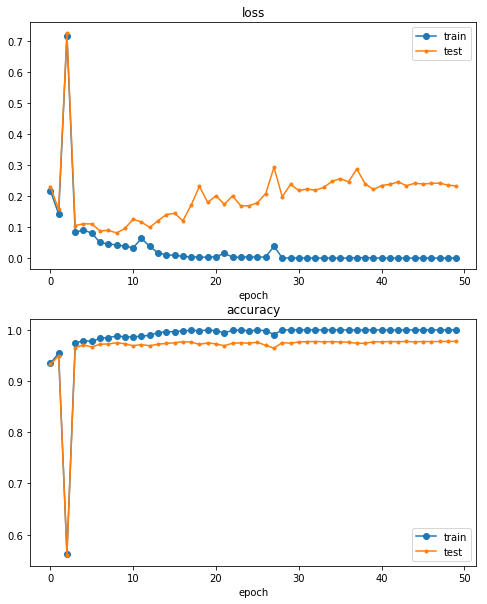

In [11]:
# vgg_16bn, weight_decay = 1e-8, 3*fc, widht=224, SGD, lr=1e-2, step_size=5, gamma=0.5, epoch =50, momentum=0.5
# ACC=0.97766, F=0.1739  ,fair_accuracy = 0.9523
plot(loss_vgg, accuracy_vgg)

### Create final submission

In [30]:
y_pred,output = predict(X_test, model_vgg, device=torch.device("cuda:3"))
result = pd.DataFrame(columns=['id', 'label'])
result['id'] = test_id
result['label'] = output
result.to_csv('submition.csv',index=False)